In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch.utils.data as loader
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import tqdm

In [0]:
class Discriminator(nn.Module):
    """
    Discriminator module:

    Especially for Celeb-A dataset, otherwise cls vector size will vary.

    Args:
        Image Tensor (-1,3,128,128)

    Output:
        src (float): Probability between 0 and 1, discriminates whether source is real or fake.
        cls (tensor, shape(c_dims,)): Returns class-wise probability, similar to that of AC-GAN (Goodfellow et.al).
    """

    def __init__(self):
        super().__init__()
        self.input_layer=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.hidden1=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.hidden2=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.hidden3=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.hidden4=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.hidden5=nn.Sequential(
            nn.Conv2d(in_channels=1024,out_channels=2048,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU()
        )
        self.src=nn.Sequential(
            nn.Conv2d(in_channels=2048,out_channels=1,kernel_size=(3,3),stride=1,padding=1,bias=False)
        )
        self.cls=nn.Sequential(
            nn.Conv2d(in_channels=2048,out_channels=c_dims,kernel_size=(1,1),stride=1,padding=0,bias=False)
        )
    def forward(self,x):
        bsize=x.size(0)
        x=self.input_layer(x)
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
        x=self.hidden4(x)
        x=self.hidden5(x)
        src=self.src(x)
        cls=self.cls(x).squeeze()
        return src,cls

In [0]:
class Generator(nn.Module):
    """
    Generator module:

    Args:
        x : Image Tensor (-1,3,128,128)
        c : Label Tensor (-1,c_dims)

    Output:
        Image Tensor (-1,3,128,128)
    """
    def __init__(self):
        super().__init__()
        self.down_sample=nn.Sequential(
            nn.Conv2d(in_channels=3+c_dims,out_channels=64,kernel_size=(7,7),stride=1,padding=3,bias=False),
            nn.InstanceNorm2d(64,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(128,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(256,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        bottle_neck=[]
        for _ in range(2):
            bottle_neck.append(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=1,padding=1,bias=False))
            bottle_neck.append(nn.InstanceNorm2d(256,affine=True,track_running_stats=True))
            bottle_neck.append(nn.ReLU(inplace=True))
        self.bottleneck=nn.Sequential(*bottle_neck)
        self.up_sample=nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(128,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(64,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(7,7),stride=1,padding=3,bias=False),
            nn.Tanh(),
        )

    def forward(self,x,c):
        c=c.view(c.size(0),c.size(1),1,1).float()
        c=c.repeat(1,1,x.size(2),x.size(3))
        x=torch.cat((x,c),dim=1)
        x=self.down_sample(x)
        x=self.bottleneck(x)
        x=self.up_sample(x)
        return x

In [0]:
from functools import partial
import torch
import os
import PIL
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, verify_str_arg, _get_confirm_token,_save_response_content,download_file_from_google_drive

class CelebA(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.
    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        attributes (list): List of attributes that you want from all 40 attributes.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        ("15GLCHkvetqYVbg4d1gWZhD9Pk7RDNa7T", "00d2c5bc6d35e252742224ab0c1e8fcb", "img_align_celeba.zip"),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        ("16ZFAm82Es_MiQ51E81r69Qbh7KEH8Dfu", "75e246fa4810816ffd6ee81facbd244c", "list_attr_celeba.txt"),
        ("1LuFPVoCSub0Ewyaf3QzNpmtRTDp9Tml8", "32bd1bd63d3c78cd57e08160ec5ed1e2", "identity_CelebA.txt"),
        ("10u_vSZfCadbWKAhQyNDuyuhF1tsCEr2B", "00566efa6fedff7a56946cd1c10f1c16", "list_bbox_celeba.txt"),
        ("1VcOp1jra9oxLDmUHdjTqkifMqMkDnQEx", "cc24ecafdb5b50baae59b03474781f8c", "list_landmarks_align_celeba.txt"),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        ("1kiE5zyobrmnw49R-ca6EfHbRNWxVq33K", "d32c9cbf5e040fd4025c592c306e6668", "list_eval_partition.txt"),
    ]

    def __init__(self, root, attributes, split="train", target_type="attr", transform=None,
                 target_transform=None, download=False):
        import pandas
        super(CelebA, self).__init__(root, transform=transform,
                                     target_transform=target_transform)
        self.split = split
        self.attributes=attributes
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError('target_transform is specified but target_type is empty')

        if download:
            self.download()

        # if not self._check_integrity():
        #     raise RuntimeError('Dataset not found or corrupted.' +
        #                        ' You can use download=True to download it')

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[verify_str_arg(split.lower(), "split",
                                         ("train", "valid", "test", "all"))]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(fn("list_eval_partition.txt"), delim_whitespace=True, header=None, index_col=0)
        identity = pandas.read_csv(fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0)
        bbox = pandas.read_csv(fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0)
        landmarks_align = pandas.read_csv(fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1)
        attr = pandas.read_csv(fn("list_attr_celeba.txt"), delim_whitespace=True, header=1)
        attr = attr[self.attributes]

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)

    def _check_integrity(self):
        for (_, md5, filename) in self.file_list:
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False

        # Should check a hash of the images
        return os.path.isdir(os.path.join(self.root, self.base_folder, "img_align_celeba"))

    def download(self):
        import zipfile

        for (file_id, md5, filename) in self.file_list:
            download_file_from_google_drive(file_id, os.path.join(self.root, self.base_folder), filename)

        with zipfile.ZipFile(os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r") as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        X = PIL.Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[index]))

        target = []
        for t in self.target_type:
            if t == "attr":
                target.append(self.attr[index, :])
            elif t == "identity":
                target.append(self.identity[index, 0])
            elif t == "bbox":
                target.append(self.bbox[index, :])
            elif t == "landmarks":
                target.append(self.landmarks_align[index, :])
            else:
                # TODO: refactor with utils.verify_str_arg
                raise ValueError("Target type \"{}\" is not recognized.".format(t))

        if self.transform is not None:
            X = self.transform(X)

        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None

        return X, target

    def __len__(self):
        return len(self.attr)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return '\n'.join(lines).format(**self.__dict__)

In [0]:
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(178),
    transforms.Resize(size=64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])
dataset=CelebA(root='./',attributes=['Blond_Hair','Black_Hair','Brown_Hair','Young','Male'],transform=transform,download=True)

Using downloaded and verified file: ./celeba/img_align_celeba.zip
Using downloaded and verified file: ./celeba/list_attr_celeba.txt
Using downloaded and verified file: ./celeba/identity_CelebA.txt
Using downloaded and verified file: ./celeba/list_bbox_celeba.txt
Using downloaded and verified file: ./celeba/list_landmarks_align_celeba.txt
Using downloaded and verified file: ./celeba/list_eval_partition.txt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


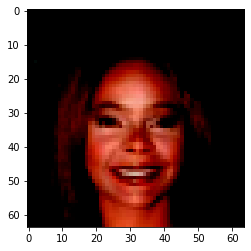

tensor([0, 0, 0, 1, 0])


In [0]:
im1,l1=dataset[2348]
plt.imshow(im1.squeeze().numpy().transpose((1,2,0)))
plt.show()
print(l1)
c_dims=len(l1)

In [0]:
num_epochs=1
batchsize=16
d_times=5
lamb_cls=1
lamb_rec=10
num_intervals=5

In [0]:
D_=Discriminator().to(device)
G_=Generator().to(device)
optimD=optim.Adam(D_.parameters(),lr=1e-4,betas=(0.5,0.999))
optimG=optim.Adam(G_.parameters(),lr=1e-4,betas=(0.5,0.999))
lambda1=lambda epoch: (-(1e-5)*epoch + 2e-4)
if num_epochs>=10:
    schedulerD=optim.lr_scheduler.LambdaLR(optimD,lambda1)
    schedulerG=optim.lr_scheduler.LambdaLR(optimG,lambda1)

In [0]:
print(c_dims)

5


In [0]:
print(summary(G_,[(3,32,32),(c_dims,1)]))
print(summary(D_,(3,64,64)))

In [0]:
data_loader=loader.DataLoader(dataset,batch_size=batchsize)

In [0]:
def fakeLabels(lth):
    """
    lth (int): no of labels required
    """
    label=torch.tensor([])
    for i in range(lth):
        arr=np.zeros(c_dims)
        arr[0]=1
        np.random.shuffle(arr)
        label=torch.cat((label,torch.tensor(arr).float().unsqueeze(0)),dim=0)
    return label
def classification_loss(logit,target):
    """
    Args:
        logits (tensor): outputs
        target (tensor): obvious
    """
    return F.binary_cross_entropy_with_logits(logit.float(),target.float(),size_average=False)/logit.float().size(0)

In [0]:
D_src,D_cls=D_(torch.randn(5,3,64,64).to(device))
print(D_src.shape,D_cls.shape)

torch.Size([5, 1, 1, 1]) torch.Size([5, 5])


In [0]:
g_losses=[]
d_losses=[]
import time
import warnings
warnings.filterwarnings("ignore")
for epoch in range(num_epochs):
    
    for i,data in enumerate(tqdm.notebook.tqdm(data_loader)):
        real_image, orig_labels = data[0].to(device),data[1].to(device)
        running_g_loss=.0
        running_d_loss=.0
        start=time.time()
        # Training discriminator
        optimG.zero_grad(),G_.zero_grad()
        optimD.zero_grad(),D_.zero_grad()
        target_labels=fakeLabels(orig_labels.size(0))
        D_src_real,D_cls_real=D_(real_image)

        pred=G_(real_image,target_labels)
        D_src_pred,D_cls_pred=D_(pred.detach())

        loss_adv=-torch.mean(D_src_real)+torch.mean(D_src_pred) # Adversarial Loss
        loss_cls_real=classification_loss(D_cls_pred,orig_labels) # Domain Classification Real Loss
        loss=loss_adv+lamb_cls*loss_cls_real

        D_.zero_grad(),G_.zero_grad()
        loss.backward()
        optimD.step()
        running_d_loss+=loss.item()
        # Training Generator
        if (i+1)%d_times==0:
            D_src_real,D_cls_real=D_(real_image)
            
            target_labels=fakeLabels(orig_labels.size(0))
            pred=G_(real_image,target_labels)
            D_src_pred,D_cls_pred=D_(pred)

            recombined=G_(pred,orig_labels)


            loss_cls_fake=classification_loss(D_cls_pred,target_labels)
            loss_adv=-torch.mean(D_src_pred)
            loss_rec=torch.mean(torch.abs(real_image-recombined))
            loss=loss_adv+lamb_cls*loss_cls_fake+lamb_rec*loss_rec
            
            D_.zero_grad(),G_.zero_grad()
            loss.backward()
            optimG.step()
            running_g_loss+=loss.item()

        if (i+1)%num_intervals==0:
            print('[%d/%d] iter:%d gen_loss:%.4f dis_loss:%.4f elapsed:%.4f'%(epoch+1,num_epochs,i+1,running_g_loss,running_d_loss,time.time()-start))

        d_losses.append(running_d_loss)
        g_losses.append(running_g_loss)
    if (epoch+1)>=10:
        schedulerD.step()
        schedulerG.step()

[1/1] iter:5 gen_loss:8.3510 dis_loss:3.2744 elapsed:8.0137
[1/1] iter:10 gen_loss:0.3831 dis_loss:-20.6800 elapsed:8.0346
[1/1] iter:15 gen_loss:-331.0416 dis_loss:-935.1260 elapsed:8.0056
[1/1] iter:20 gen_loss:-3645.2075 dis_loss:-12940.7881 elapsed:8.0699
[1/1] iter:25 gen_loss:-26001.2285 dis_loss:-99478.0938 elapsed:8.0780
[1/1] iter:30 gen_loss:-153640.0781 dis_loss:-460712.8750 elapsed:8.0259
[1/1] iter:35 gen_loss:-835665.2500 dis_loss:-1536810.3750 elapsed:8.0565
[1/1] iter:40 gen_loss:-2805126.2500 dis_loss:-2171373.2500 elapsed:8.0595
[1/1] iter:45 gen_loss:-5277871.5000 dis_loss:-2305557.7500 elapsed:8.0346
[1/1] iter:50 gen_loss:-7824373.5000 dis_loss:-3389285.7500 elapsed:8.0711
[1/1] iter:55 gen_loss:-9395641.0000 dis_loss:-7597235.0000 elapsed:8.0932
[1/1] iter:60 gen_loss:-9427922.0000 dis_loss:-17396238.0000 elapsed:8.0437
[1/1] iter:65 gen_loss:-4855922.5000 dis_loss:-53267008.0000 elapsed:8.0570
[1/1] iter:70 gen_loss:-321942.1562 dis_loss:-145222736.0000 elapsed:8

KeyboardInterrupt: ignored

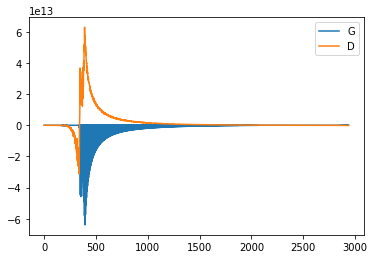

In [0]:
plt.plot(g_losses,label='G')
plt.plot(d_losses,label='D')
plt.legend()
plt.show()

In [0]:
print(g_losses[-5],d_losses[-2])

215868391424.0 -165061410816.0


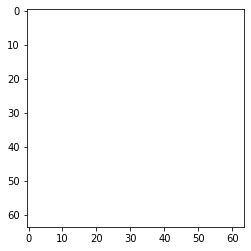

In [0]:
D_.eval()
G_.eval()
sample=G_(im1.unsqueeze(0),torch.tensor([[0,0,0,0,1]]).to(device))
plt.imshow(sample.squeeze().detach().cpu().numpy().transpose((1,2,0)))
plt.show()

In [0]:
print(sample)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], grad_fn=<TanhBackward>)
